In [3]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## Change working directory
import os
os.chdir('/content/drive/MyDrive/CV_Turtle')
# 
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/CV_Turtle


In [4]:
SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891
'''
%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
   %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
   %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
   %sx rm "{TAR_PATH}"
'''
print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


In [5]:
import pandas as pd
import requests
import io
import urllib.parse

BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))

# Read in csv files.
train = read_csv_from_web('train.csv')
test = read_csv_from_web('test.csv')
sample_submission = read_csv_from_web('sample_submission.csv')

# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

In [6]:
train.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [7]:
test.head()

,image_id,image_location
0,ID_6NEDKOYZ,top
1,ID_57QZ4S9N,left
2,ID_OCGGJS5X,left
3,ID_R2993S3S,top
4,ID_2E011NB0,left


In [8]:
train.shape, test.shape

((2145, 3), (490, 2))

In [9]:
print(f"There are {train.turtle_id.nunique()} unique turtles in the train set.")

There are 100 unique turtles in the train set.


In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_images_per_turtle = pd.value_counts(train['turtle_id'])

In [11]:
train_images_per_turtle

t_id_ROFhVsy2    77
t_id_hRzOoJ2t    68
t_id_VP2NW7aV    58
t_id_Kf73l69A    57
t_id_dVQ4x3wz    47
                 ..
t_id_Lhp87PBX    10
t_id_Dv4O8bOM    10
t_id_p77GDtzg     9
t_id_OqU1NWEA     9
t_id_J5dngbNA     8
Name: turtle_id, Length: 100, dtype: int64

In [12]:
import functools
from PIL import Image  # Image utilities.
import tqdm
import numpy as np

In [13]:
pd.unique(train['turtle_id'])

array(['t_id_VP2NW7aV', 't_id_qZ0iZYsC', 't_id_3b65X5Lw', 't_id_YjXYTCGC',
       't_id_d6aYXtor', 't_id_ksTLswDT', 't_id_hRzOoJ2t', 't_id_utw0thCe',
       't_id_k1rScFLB', 't_id_n2FBHk6d', 't_id_ZfvZBX4Q', 't_id_G5eoqwD8',
       't_id_FBsGDJhU', 't_id_Ts5LyVQz', 't_id_NW7wn8TC', 't_id_JI6ba2Yx',
       't_id_ifWwxWF4', 't_id_uIlC9Gfo', 't_id_dVQ4x3wz', 't_id_3K93fQBS',
       't_id_IlO9BOKc', 't_id_DPYQnZyv', 't_id_ROFhVsy2', 't_id_BI99coHt',
       't_id_GrxmyS59', 't_id_AOWArhGb', 't_id_4XiPKIk7', 't_id_mpuNp8mf',
       't_id_stWei2Uq', 't_id_15bo4NKD', 't_id_QqeoI5F3', 't_id_Kf73l69A',
       't_id_Kc1tXDbJ', 't_id_2Yn71r7R', 't_id_iZQiE7wb', 't_id_m2JvEcsg',
       't_id_a4VYrmyA', 't_id_UVQa4BMz', 't_id_tjWepji1', 't_id_BXWccqAn',
       't_id_1KIezxkh', 't_id_e9i3Lbq4', 't_id_bYageLYA', 't_id_8b8sprYe',
       't_id_2QmcRkNj', 't_id_9GFmcOd5', 't_id_smNwfXAT', 't_id_hibDzPAP',
       't_id_D3kHUEgp', 't_id_B7LaSiac', 't_id_fjHGjp1w', 't_id_gJaKYxBQ',
       't_id_72SiiZCp', '

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['image_id'], train['turtle_id'], test_size=0.20, random_state=42, stratify=train['turtle_id'])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42, stratify=y_test)

print(X_train.shape, X_test.shape, X_val.shape ,y_train.shape, y_test.shape, y_val.shape)

train_ds = pd.concat([X_train, y_train], axis=1)
train_ds['type'] = "train"
test_ds = pd.concat([X_test, y_test], axis=1)
test_ds['type'] = "test"
val_ds = pd.concat([X_val, y_val], axis=1)
val_ds['type'] = "val"

(1716,) (214,) (215,) (1716,) (214,) (215,)


In [15]:
train_ds

,image_id,turtle_id,type
708,ID_UC0NFKIH,t_id_UVQa4BMz,train
59,ID_IZB1O90H,t_id_2QmcRkNj,train
614,ID_L4O6H0WC,t_id_8b8sprYe,train
2011,ID_BUYIHPE9,t_id_tjWepji1,train
761,ID_2HBGMZLT,t_id_BI99coHt,train
...,...,...,...
1126,ID_3JHL0XDW,t_id_AOWArhGb,train
697,ID_DBYS9YUA,t_id_uJXT7dGu,train
165,ID_XAO3YF62,t_id_D0gA44av,train
52,ID_P7LXRA4M,t_id_4XiPKIk7,train


In [16]:
dataset = pd.concat([train_ds,test_ds,val_ds], axis=0)

In [17]:
dataset

,image_id,turtle_id,type
708,ID_UC0NFKIH,t_id_UVQa4BMz,train
59,ID_IZB1O90H,t_id_2QmcRkNj,train
614,ID_L4O6H0WC,t_id_8b8sprYe,train
2011,ID_BUYIHPE9,t_id_tjWepji1,train
761,ID_2HBGMZLT,t_id_BI99coHt,train
...,...,...,...
1616,ID_OGY3G91Y,t_id_AOWArhGb,val
762,ID_I9VYL0O6,t_id_p77GDtzg,val
2105,ID_SC9XGO7W,t_id_e9i3Lbq4,val
618,ID_QDJ0DNWU,t_id_fjHGjp1w,val


In [18]:
dataset['image_id'] = IMAGE_DIR + "/" + dataset['image_id'].astype(str) + ".JPG"

In [19]:
dataset.to_csv('./dataset.csv')

In [20]:
train_ds = dataset.loc[dataset['type'] == "train"]
test_ds = dataset.loc[dataset['type'] == "test"]
val_ds = dataset.loc[dataset['type'] == "val"]

In [21]:
train_ds

,image_id,turtle_id,type
708,./turtle_recall/images/ID_UC0NFKIH.JPG,t_id_UVQa4BMz,train
59,./turtle_recall/images/ID_IZB1O90H.JPG,t_id_2QmcRkNj,train
614,./turtle_recall/images/ID_L4O6H0WC.JPG,t_id_8b8sprYe,train
2011,./turtle_recall/images/ID_BUYIHPE9.JPG,t_id_tjWepji1,train
761,./turtle_recall/images/ID_2HBGMZLT.JPG,t_id_BI99coHt,train
...,...,...,...
1126,./turtle_recall/images/ID_3JHL0XDW.JPG,t_id_AOWArhGb,train
697,./turtle_recall/images/ID_DBYS9YUA.JPG,t_id_uJXT7dGu,train
165,./turtle_recall/images/ID_XAO3YF62.JPG,t_id_D0gA44av,train
52,./turtle_recall/images/ID_P7LXRA4M.JPG,t_id_4XiPKIk7,train


In [22]:
import os

os.path.exists('./dizzy_turtle/')

True

In [23]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# Define your data generator

def our_preprocessing_function(filename):
    #Combines all the transformations
    img_blur = cv2.GaussianBlur(filename, (3,3), 0)
    final_img = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)
    final_img = final_img[:, :, np.newaxis]
    return final_img
def dizzy(img):
    dizzy_img = img
    b = len(dizzy_img[1])
    dizzy_img[:, 10:-1, 0] = img[:,0:-11, 0]
    dizzy_img[:, 0:-11, 2] = img[:,10:-1, 2]
    return dizzy_img

def Qfactor_Lowres(img):
    pass
    return img

def threshold(img):
    pass
    return img

def hist_eq(img):
    pass
    return img
dizzy_gen = ImageDataGenerator(
# rotation_range=45,
# horizontal_flip=True,
  preprocessing_function = dizzy
)

test_gen = ImageDataGenerator(rescale = 1./255)

train_data = test_gen.flow_from_dataframe(train_ds, x_col='image_id', y_col='turtle_id', seed = 42, batch_size = 32, shuffle = True, class_mode="categorical",target_size = (224,224), save_to_dir="./dizzy_turtle/train/")
val_data = test_gen.flow_from_dataframe(val_ds, x_col='image_id', y_col='turtle_id', seed = 42, batch_size = 32, shuffle = True, class_mode="categorical",target_size = (224,224), save_to_dir="./dizzy_turtle/val/")
test_data = test_gen.flow_from_dataframe(test_ds, x_col='image_id', y_col='turtle_id', seed = 42, batch_size = 32, shuffle = True, class_mode="categorical",target_size = (224,224), save_to_dir="./dizzy_turtle/test/")

Found 1716 validated image filenames belonging to 100 classes.
Found 215 validated image filenames belonging to 100 classes.
Found 214 validated image filenames belonging to 100 classes.


In [ ]:
## Create model
import tensorflow as tf
# from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

num_classes = 100

#simple CNN model with 3 conv layers and 1 FC layer

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [1]:
# Computational Variational Autoencoder (CVAE)

latent_dim = 4  # Can be set 

def sampling(mu_log_variance):
    mu, log_variance = tf.split(mu_log_variance, num_or_size_splits=2, axis=1)
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tf.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

def encoder():
  pass
  return tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    #tf.keras.layers.Rescaling(1./255, input_shape = (224, 224, 1)),

    tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_1"),
    tf.keras.layers.BatchNormalization(name="encoder_norm_1"),
    tf.keras.layers.LeakyReLU(name="encoder_activ_layer_1"),
    

    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2"),
    tf.keras.layers.BatchNormalization(name="encoder_norm_2"),
    tf.keras.layers.LeakyReLU(name="encoder_activ_layer_2"),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3"),
    tf.keras.layers.BatchNormalization(name="encoder_norm_3"),
    tf.keras.layers.LeakyReLU(name="encoder_activ_layer_3"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_dim, name ="encoder_mu_log_variance")
    #tf.keras.layers.Lambda(sampling, name="encoder_output")
  ], 
  name = "encoder_model")


In [ ]:
# Flatten version of autoencoder

def build_autoencoder(img_shape, feature_dim):
    # The encoder
    encoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=img_shape),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(feature_dim, name = "intermediate_features")                               
    ])


    # The decoder
    decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(feature_dim),
      tf.keras.layers.Dense(np.prod(img_shape)),
      tf.keras.layers.Reshape(img_shape)
    ])

    return encoder, decoder

In [ ]:
IMG_SHAPE = (224,224, 3)
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = tf.keras.layers.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 1000)              150529000 
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       150678528 
                                                                 
Total params: 301,207,528
Trainable params: 301,207,528
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
train_enc_data = test_gen.flow_from_dataframe(train_ds,  x_col="image_id", y_col="image_id", seed = 42, batch_size = 32, shuffle = True, class_mode="input", target_size = (224,224), classes = None, save_to_dir="./encoder_img/")
val_enc_data = test_gen.flow_from_dataframe(val_ds,  x_col="image_id", y_col="image_id", seed = 42, batch_size = 32, shuffle = True, class_mode="input", target_size = (224,224), classes = None)
test_enc_data = test_gen.flow_from_dataframe(test_ds, x_col="image_id", y_col="image_id", seed = 42, batch_size = 32, shuffle = True, class_mode="input", target_size = (224,224), classes = None)

Found 1716 validated image filenames.
Found 215 validated image filenames.
Found 214 validated image filenames.


In [ ]:
with tf.device('/device:GPU:0'):

  history_enc = autoencoder.fit(
    train_enc_data,
    epochs =4,
    validation_data = val_enc_data
  )

Epoch 1/4
54/54 [==============================] - 481s 9s/step - loss: 52.3437 - val_loss: 0.5336
Epoch 2/4
54/54 [==============================] - 105s 2s/step - loss: 0.1542 - val_loss: 0.0622
Epoch 3/4
54/54 [==============================] - 105s 2s/step - loss: 0.0624 - val_loss: 0.0534
Epoch 4/4
54/54 [==============================] - 104s 2s/step - loss: 0.0548 - val_loss: 0.0488


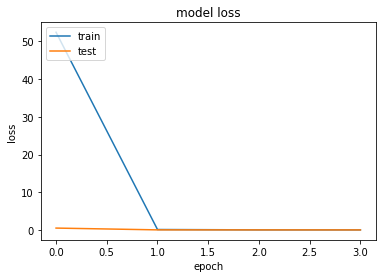

In [ ]:
plt.plot(history_enc.history['loss'])
plt.plot(history_enc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Img_autoenc = autoencoder.predict(train_enc_data)


In [ ]:
print(Img_autoenc[0].shape)

(224, 224, 3)


In [ ]:
import h5py

filename = 'Autoenc_1000.h5'
print(filename)

Autoenc_1000.h5


In [ ]:
autoenc_h5 = h5py.File(filename, 'w')
autoenc_h5.create_dataset('dataset_1', data=Img_autoenc)

<HDF5 dataset "dataset_1": shape (1716, 224, 224, 3), type "<f4">

In [ ]:
autoenc_h5.close()

In [ ]:
h5f = h5py.File(filename,'r')
img_arr = h5f['dataset_1'][:]
h5f.close()

In [ ]:
# Generate sample image with 1000 hidden layers

test_img = img_arr[0]*255
cv2.imwrite("color_img_2.jpg", test_img)

True

In [ ]:
zip(img_arr, train_ds['turtle_id'])

In [ ]:
## Load model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

model_res = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights=None, input_shape=(224, 224, 3),
)

model_res.trainable = True

# Create new model on top.
#x = model_res(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(model_res.output)
outputs = keras.layers.Dense(num_classes)(x)

# Resnet50 model
model = keras.models.Model(inputs = [model_res.input], outputs= [outputs])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
test_enc = encoder()
test_enc.summary()

ValueError: ignored

In [ ]:
# Concatanate features from autoencoder with ImgNet features

all_features = keras.layers.Concatenate()([x, encoder.output])
new_output = keras.layers.Dense(100)(all_features)
Resnet50_enc_model = keras.models.Model(inputs=[model_res.input, encoder.input], outputs=[new_output])


In [ ]:
Resnet50_enc_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
import cv2
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
  optimizer=opt,
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])



In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Resnet50 model with Imagenet weights

with tf.device('/device:GPU:0'):
  history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=10,
  use_multiprocessing=True
)

Epoch 1/10
54/54 [==============================] - 95s 2s/step - loss: 4.8182 - accuracy: 0.0192 - val_loss: 4.5799 - val_accuracy: 0.0326
Epoch 2/10
54/54 [==============================] - 91s 2s/step - loss: 4.5142 - accuracy: 0.0350 - val_loss: 4.7543 - val_accuracy: 0.0186
Epoch 3/10
54/54 [==============================] - 79s 1s/step - loss: 4.3902 - accuracy: 0.0460 - val_loss: 5.1779 - val_accuracy: 0.0186
Epoch 4/10
54/54 [==============================] - 78s 1s/step - loss: 4.2621 - accuracy: 0.0542 - val_loss: 5.5284 - val_accuracy: 0.0140
Epoch 5/10
54/54 [==============================] - 89s 2s/step - loss: 4.1491 - accuracy: 0.0641 - val_loss: 6.4645 - val_accuracy: 0.0093
Epoch 6/10
54/54 [==============================] - 78s 1s/step - loss: 4.0308 - accuracy: 0.0886 - val_loss: 7.6059 - val_accuracy: 0.0047
Epoch 7/10
54/54 [==============================] - 81s 1s/step - loss: 3.9171 - accuracy: 0.0932 - val_loss: 6.4207 - val_accuracy: 0.0140
Epoch 8/10
54/54 [==

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  with tf.device("/gpu:0"):

In [ ]:
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=10,
  use_multiprocessing=True
)

In [ ]:
# Extracting 1 batch of image

train_img_batch =iter((train_data))
val_img_batch =iter((val_data))

In [ ]:
import cv2
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Resnet 50 model with CVAE autoencoder features on 1 batch
Resnet50_enc_model.compile(
  optimizer=opt,
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = Resnet50_enc_model.fit(
  x = [train_img_batch, train_img_batch],
  y = train_label_batch,
  steps_per_epoch = 32,
  validation_steps = 32,
  validation_data=([val_img_batch, val_img_batch],val_label_batch ),
  epochs=100,
  use_multiprocessing=True
)




Epoch 1/100
32/32 [==============================] - 22s 489ms/step - loss: 1.4786 - accuracy: 0.5000 - val_loss: 6.2978 - val_accuracy: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 14s 452ms/step - loss: 1.5271 - accuracy: 0.4688 - val_loss: 6.6104 - val_accuracy: 0.0312
Epoch 3/100
32/32 [==============================] - 14s 453ms/step - loss: 1.3312 - accuracy: 0.5312 - val_loss: 6.8543 - val_accuracy: 0.0312
Epoch 4/100
32/32 [==============================] - 14s 456ms/step - loss: 1.2534 - accuracy: 0.5000 - val_loss: 7.1111 - val_accuracy: 0.0312
Epoch 5/100
32/32 [==============================] - 14s 452ms/step - loss: 1.1931 - accuracy: 0.6562 - val_loss: 7.3714 - val_accuracy: 0.0000e+00
Epoch 6/100
32/32 [==============================] - 14s 455ms/step - loss: 1.1500 - accuracy: 0.5625 - val_loss: 7.6282 - val_accuracy: 0.0312
Epoch 7/100
32/32 [==============================] - 17s 533ms/step - loss: 1.1055 - accuracy: 0.5938 - val_loss: 7.8813 - val_a

KeyboardInterrupt: ignored